# How to train and deploy Learning To Rank

TODO: udpate the link to elastic/elasticsearch-labs instead of my fork before merging.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/afoucret/elasticsearch-labs/blob/ltr-notebook/notebooks/learning-to-rank/01-learning-to-rank.ipynb)

In this notebook we will see an example on how to train a Learning To Rank model using [XGBoost](https://xgboost.ai/) and how to deploy it to be used as a rescorer in Elasticsearch.


**Notes about the Learning To Rank feature:**
- The Learning To Rank feature is available for Elastic Stack versions 8.12.0 and newer and requires a Platinum subscription or higher.
- The Learning To rank is experimental and may be changed or removed completely in future releases. Elastic will make a best effort to fix any issues, but experimental features are not supported to the same level as generally available (GA) features.
 


## Install required packages

First we will be installing packages required for our example.

In [99]:
# TODO: when eland 8.12.1 is released, we can avoid installing from github main:
!pip install -qU git+https://github.com/elastic/eland@main
!pip install -qU elasticsearch "eland[scikit-learn]" xgboost tqdm

from tqdm import tqdm

# Setup the progress bar so we can use progress_apply in the notebook.
tqdm.pandas()

## Configure your Elasticsearch deployment

For this example, we will be using an [Elastic Cloud](https://www.elastic.co/guide/en/cloud/current/ec-getting-started.html) deployment (available with a [free trial](https://cloud.elastic.co/registration?utm_source=github&utm_content=elasticsearch-labs-notebook)).

In [100]:
import getpass
from elasticsearch import Elasticsearch

# https://www.elastic.co/search-labs/tutorials/install-elasticsearch/elastic-cloud#finding-your-cloud-id
ELASTIC_CLOUD_ID = getpass("Elastic Cloud ID: ")

# https://www.elastic.co/search-labs/tutorials/install-elasticsearch/elastic-cloud#creating-an-api-key
ELASTIC_API_KEY = getpass("Elastic Api Key: ")

# Create the client instance
es_client = Elasticsearch(
    # For local development
    # hosts=["http://localhost:9200"]
    cloud_id=ELASTIC_CLOUD_ID,
    api_key=ELASTIC_API_KEY,
)

client_info = es_client.info()

f"Successfully connected to cluster {client_info['cluster_name']} (version {client_info['version']['number']})"

'Successfully connected to cluster bd63f706e18b476aacb5cb0aaeb5f0bd (version 8.12.0)'

## Configuring the dataset

In this example notebook we will use a dataset derived from [MSRD](https://github.com/metarank/msrd/tree/master) (Movie Search Ranking Dataset).

The dataset is available [here](https://github.com/elastic/elasticsearch-labs/tree/main//ltr-notebook/notebooks/learning-to-rank/sample_data/) and contains the following files:

- **movies_corpus.jsonl.gz**: The movies dataset which will be indexed.
- **movies_judgements.tsv.gz**: A file containing relevance judgments for a set of queries.
- **movies_index_settings.json**: Settings to be applied to the documents and index.

In [101]:
from urllib.parse import urljoin

# TODO: use elastic/elasticsearch-labs instead of afoucret/elasticsearch-labs before merging the PR.

DATASET_BASE_URL = "https://raw.githubusercontent.com/afoucret/elasticsearch-labs/ltr-notebook/notebooks/learning-to-rank/sample_data/"

CORPUS_URL = urljoin(DATASET_BASE_URL, "movies_corpus.jsonl.gz")
JUDGEMENTS_FILE_URL = urljoin(DATASET_BASE_URL, "movies_judgments.tsv.gz")
INDEX_SETTINGS_URL = urljoin(DATASET_BASE_URL, "movies_index_settings.json")

 ## Importing the document corpus

This step will import the documents of the corpus into the `movies` index .

Documents contains the following fields:

| Field name   | Description                                 |
|--------------|---------------------------------------------|
| `id`         | Id of the document                          |
| `title`      | Movie title                                 |
| `overview`   | A short description of the movie            |
| `actors`     | List of actors in the movies                |
| `director`   | Director of the movie                       |
| `characters` | List of characters that appear in the movie |
| `genres`     | Genres of the movie                         |
| `year`       | Year the movie was released                 |
| `budget`     | Budget of the movies in USD                 |
| `votes`      | Number of votes received by the movie       |
| `rating`     | Average rating of the movie                 |
| `popularity` | Number use to measure the movie popularity  |
| `tags`       | A list of tags for the movies               |



In [103]:
import json
import elasticsearch.helpers as es_helpers
import pandas as pd
from urllib.request import urlopen

MOVIE_INDEX = "movies"

# Delete index
print("Deleting index if it already exists:", MOVIE_INDEX)
es_client.options(ignore_status=[400, 404]).indices.delete(index=MOVIE_INDEX)

print("Creating index:", MOVIE_INDEX)
index_settings = json.load(urlopen(INDEX_SETTINGS_URL))
es_client.indices.create(index=MOVIE_INDEX, **index_settings)

print(f"Loading the corpus from {CORPUS_URL}")
corpus_df = pd.read_json(CORPUS_URL, lines=True)

print(f"Indexing the corpus into {MOVIE_INDEX} ...")
bulk_result = es_helpers.bulk(
    es_client,
    actions=[
        {"_id": movie["id"], "_index": MOVIE_INDEX, **movie}
        for movie in corpus_df.to_dict("records")
    ],
)
print(f"Indexed {bulk_result[0]} documents into {MOVIE_INDEX}")

Deleting index if it already exists: movies
Creating index: movies
Loading the corpus from https://raw.githubusercontent.com/afoucret/elasticsearch-labs/ltr-notebook/notebooks/learning-to-rank/sample_data/movies_corpus.jsonl.gz
Indexing the corpus into movies ...
Indexed 9751 documents into movies


## Loading the judegment list

Judgemnent list provides human judgement that will be used to train our Learning To Rank model.

Each row represents a query-document pair with an associated relevance grade and contains the following columns:

| Column    | Description                                                            |
|-----------|------------------------------------------------------------------------|
| `query_id`| Pair for the same query are grouped together and received a unique id. |
| `query`   | Actual text for the query.                                             |
| `doc_id`  | Id of the document.                                                    |
| `grade`   | The relevance grade of the document for the query.                     |


**Note:**

In our notebook the relevance grade is a binary value (relevant or not relavant).
Instread of a binary judgement, you can also use a number that represent the degree of relevance (e.g. from `0` to `4`).

In [ ]:
judgments_df = pd.read_csv(JUDGEMENTS_FILE_URL, delimiter="\t")
judgments_df

,query_id,query,doc_id,grade
0,qid:5141,insidious 2 netflix,846433,0
1,qid:5141,insidious 2 netflix,49018,1
2,qid:5141,insidious 2 netflix,38234,0
3,qid:5141,insidious 2 netflix,567604,0
4,qid:5141,insidious 2 netflix,269795,0
...,...,...,...,...
384750,qid:3383,2013 the wolverine,263115,0
384751,qid:3383,2013 the wolverine,25913,0
384752,qid:3383,2013 the wolverine,567604,0
384753,qid:3383,2013 the wolverine,533535,0


## Configure feature extraction

Features and the inputs to our model. They represent information about the query alone, a result document alone or a result document in the context of a query, as in the case of BM25 scores.

Features are defined using standard templated queries and the Query DSL.

To simplify defining and iterating on feature extraction during training, we've exposed some primitives directly in `eland`.

In [105]:
from eland.ml.ltr import LTRModelConfig, QueryFeatureExtractor

ltr_config = LTRModelConfig(
    feature_extractors=[
        # For the following field we want to use the score of the match query for the field as a features:
        QueryFeatureExtractor(
            feature_name="title_bm25", query={"match": {"title": "{{query}}"}}
        ),
        QueryFeatureExtractor(
            feature_name="actors_bm25", query={"match": {"actors": "{{query}}"}}
        ),
        # We could also use a more strict matching clause as an additional features. Here we want all the terms of our query to match.
        QueryFeatureExtractor(
            feature_name="title_all_terms_bm25",
            query={
                "match": {
                    "title": {"query": "{{query}}", "minimum_should_match": "100%"}
                }
            },
        ),
        QueryFeatureExtractor(
            feature_name="actors_all_terms_bm25",
            query={
                "match": {
                    "actors": {"query": "{{query}}", "minimum_should_match": "100%"}
                }
            },
        ),
        # Also we can use a script_score query to get the document field values directly as a feature.
        QueryFeatureExtractor(
            feature_name="popularity",
            query={
                "script_score": {
                    "query": {"exists": {"field": "popularity"}},
                    "script": {"source": "return doc['popularity'].value;"},
                }
            },
        ),
    ]
)

## Building the training dataset

Now that we have our basic datasets loaded, and feature extraction configured, we'll use our judgement list to come up with the final dataset for training. The dataset will consist of rows containing `<query, document>` pairs, as well as all of the features we need to train the model. To generate this dataset, we'll run each query from the judgement list and add the extracted features as columns for each of the labelled result documents in the judgement list.

For example, if we have a query `q1` with two labelled documents `d3` and `d9`, the training dataset will end up with two rows — one for each of the pairs `<q1, d3>` and `<q1, d9>`.

Note that because this executes queries on your Elasticsearch cluster, the time to run this operation will vary depending on where the cluster is versus where this notebook runs. For example, if you run the notebook on the same server or host as the Elasticsearch cluster, this operation tends to run very quickly on the sample dataset (< 2 mins).

In [ ]:
import numpy

from eland.ml.ltr import FeatureLogger

# First we create a feature logger that will be used to query Elasticsearch to retrieve the features:
feature_logger = FeatureLogger(es_client, MOVIE_INDEX, ltr_config)


# This method will be applied for each group of query in the judgment log:
def _extract_query_features(query_judgements_group):
    # Retrieve document ids in the query group as strings.
    doc_ids = query_judgements_group["doc_id"].astype("str").to_list()

    # Resolve query paras for the current query group (e.g.: {"query": "batman"}).
    query_params = {"query": query_judgements_group["query"].iloc[0]}

    # Extract the features for the documents in the query group:
    doc_features = feature_logger.extract_features(query_params, doc_ids)

    # Adding a column to the dataframe for each features:
    for feature_index, feature_name in enumerate(ltr_config.feature_names):
        query_judgements_group[feature_name] = numpy.array([doc_features[doc_id][feature_index] for doc_id in doc_ids])

    return query_judgements_group


judgments_with_features = judgments_df.groupby("query_id", group_keys=False).progress_apply(_extract_query_features)

judgments_with_features

100%|██████████| 16279/16279 [01:28<00:00, 183.72it/s]


,query_id,query,doc_id,grade,title_bm25,actors_bm25,title_all_terms_bm25,popularity
0,qid:5141,insidious 2 netflix,846433,0,NaN,9.555378,NaN,13.628
1,qid:5141,insidious 2 netflix,49018,1,9.857398,NaN,NaN,64.003
2,qid:5141,insidious 2 netflix,38234,0,NaN,NaN,NaN,143.211
3,qid:5141,insidious 2 netflix,567604,0,NaN,NaN,NaN,32.913
4,qid:5141,insidious 2 netflix,269795,0,3.809668,NaN,NaN,21.058
...,...,...,...,...,...,...,...,...
384750,qid:3383,2013 the wolverine,263115,0,NaN,NaN,NaN,68.287
384751,qid:3383,2013 the wolverine,25913,0,NaN,NaN,NaN,21.026
384752,qid:3383,2013 the wolverine,567604,0,NaN,NaN,NaN,32.913
384753,qid:3383,2013 the wolverine,533535,0,NaN,NaN,NaN,34.773


## Create and train the model

The LTR rescorer supports XGBRanker trained models.

You will find more information on XGBRanker model in the xgboost [documentation](https://xgboost.readthedocs.io/en/latest/tutorials/learning_to_rank.html).

In [125]:
from xgboost import XGBRanker
from sklearn.model_selection import GroupShuffleSplit


# Create the ranker model:
ranker = XGBRanker(
    objective="rank:ndcg",
    eval_metric=["ndcg@10"],
    early_stopping_rounds=20,
    n_estimators=200,
)

# Shaping training and eval data in the expected format.
X = judgments_with_features[ltr_config.feature_names]
y = judgments_with_features["grade"]
groups = judgments_with_features["query_id"]

# Split the dataset in two parts respectively used for training and evaluation of the model.
group_preserving_splitter = GroupShuffleSplit(n_splits=1, train_size=0.7).split(X, y, groups)
train_idx, eval_idx = next(group_preserving_splitter)
train_features, eval_features = X.loc[train_idx], X.loc[eval_idx]

train_target, eval_target = y.loc[train_idx], y.loc[eval_idx]
train_query_groups, eval_query_groups = groups.loc[train_idx], groups.loc[eval_idx]

# Training the model
ranker.fit(
    X=train_features,
    y=train_target,
    group=train_query_groups.value_counts().sort_index().values,
    eval_set=[(eval_features, eval_target)],
    eval_group=[eval_query_groups.value_counts().sort_index().values],
    verbose=True,
)

[0]	validation_0-ndcg@10:0.86234
[1]	validation_0-ndcg@10:0.87022
[2]	validation_0-ndcg@10:0.87147
[3]	validation_0-ndcg@10:0.87229
[4]	validation_0-ndcg@10:0.87288
[5]	validation_0-ndcg@10:0.87311
[6]	validation_0-ndcg@10:0.87315
[7]	validation_0-ndcg@10:0.87361
[8]	validation_0-ndcg@10:0.87451
[9]	validation_0-ndcg@10:0.87493
[10]	validation_0-ndcg@10:0.87514
[11]	validation_0-ndcg@10:0.87553
[12]	validation_0-ndcg@10:0.87564
[13]	validation_0-ndcg@10:0.87650
[14]	validation_0-ndcg@10:0.87653
[15]	validation_0-ndcg@10:0.87679
[16]	validation_0-ndcg@10:0.87700
[17]	validation_0-ndcg@10:0.87749
[18]	validation_0-ndcg@10:0.87754
[19]	validation_0-ndcg@10:0.87794
[20]	validation_0-ndcg@10:0.87796
[21]	validation_0-ndcg@10:0.87837
[22]	validation_0-ndcg@10:0.87902
[23]	validation_0-ndcg@10:0.87904
[24]	validation_0-ndcg@10:0.87910
[25]	validation_0-ndcg@10:0.87962
[26]	validation_0-ndcg@10:0.87962
[27]	validation_0-ndcg@10:0.87980
[28]	validation_0-ndcg@10:0.88025
[29]	validation_0-ndcg@1

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=20, enable_categorical=False,
          eval_metric=['ndcg@10'], feature_types=None, gamma=None,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=None, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=200,
          n_jobs=None, num_parallel_tree=None, random_state=None, ...)

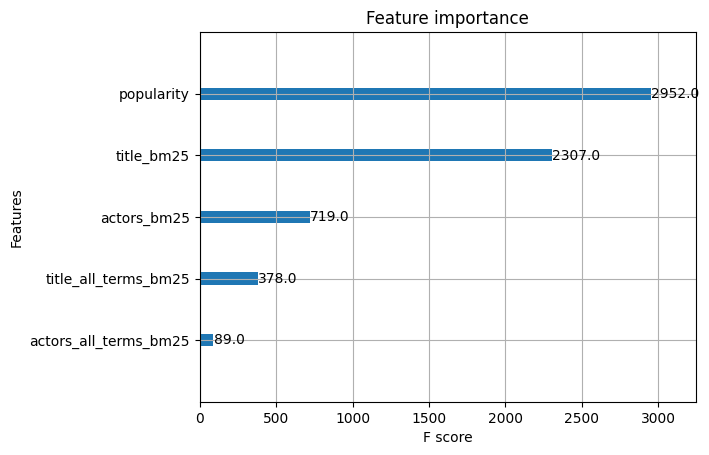

In [126]:
from xgboost import plot_importance

plot_importance(ranker, importance_type="weight");

## Importing the model to Elasticsearch

Once the model is trained you will be able to use Eland to send it to Elasticsearch.

Please note that the `MLModel.import_ltr_model` method contains the `LTRModelConfig` object in order to associate the feature extraction with the model.


In [127]:
from eland.ml import MLModel

LEARNING_TO_RANK_MODEL_ID="ltr-model-xgboost"

MLModel.import_ltr_model(
    es_client=es_client,
    model=ranker,
    model_id=LEARNING_TO_RANK_MODEL_ID,
    ltr_model_config=ltr_config,
    es_if_exists="replace",
)

/Users/afoucret/git/elasticsearch-labs/.venv/lib/python3.9/site-packages/eland/ml/ml_model.py:550: ElasticsearchWarning: The default [remove_binary] value of 'false' is deprecated and will be set to 'true' in a future release. Set [remove_binary] explicitly to 'true' or 'false' to ensure no behavior change.
  self._client.options(ignore_status=404).ml.delete_trained_model(


## Using the rescorer

Once the model is uploaded to Elasticsearch, you will be able to use it as a rescorer in the _search API, as shown in this example:

```
POST /_search
{
   "query" : {
      "multi_match" : {
         "query": "star wars",
         "field": ["title", "overview", "actors", "director", "tags", "characters"]
      }
   },
   "rescore" : {
      "window_size" : 50,
      "learning_to_rank" : {
         "model_id": "ltr-model-xgboost",
         "params": { 
            "query": "star wars"
         }
      }
   }
}
```

In [140]:
query = "star wars"

# First let's display the result when not using the rescorer:
search_fields = ["title", "overview", "actors", "director", "tags", "characters"]
bm25_query = { "multi_match": { "query": query, "fields": search_fields } }

bm25_search_response = es_client.search(index=MOVIE_INDEX, query=bm25_query)

[
    (movie["_source"]["title"], movie["_score"], movie["_id"])
    for movie in bm25_search_response['hits']['hits']
]

[('Star Wars', 10.972473, '11'),
 ('Star Wars: The Clone Wars', 9.924128, '12180'),
 ('After Porn Ends 2', 9.613241, '440249'),
 ('Andor: A Disney+ Day Special Look', 8.982841, '1022100'),
 ("Family Guy Presents: It's a Trap!", 8.840657, '278427'),
 ('Star Wars: The Rise of Skywalker', 8.053794, '181812'),
 ('Star Wars: The Force Awakens', 8.053794, '140607'),
 ('Star Wars: The Last Jedi', 8.053794, '181808'),
 ('Solo: A Star Wars Story', 8.053794, '348350'),
 ('The Star Wars Holiday Special', 8.053794, '74849')]

In [141]:
# Now let's display result when using the rescorer:

ltr_rescorer = {
    "learning_to_rank": {
        "model_id": LEARNING_TO_RANK_MODEL_ID,
        "params": {"query": query},
    },
    "window_size": 100,
}

rescored_search_response = es_client.search(index=MOVIE_INDEX, query=bm25_query, rescore=ltr_rescorer)

[
    (movie["_source"]["title"], movie["_score"], movie["_id"])
    for movie in rescored_search_response["hits"]["hits"]
]

[('Star Wars: The Clone Wars', 3.809828, '12180'),
 ('Star Wars', 3.4305632, '11'),
 ('Star Wars: The Last Jedi', 2.3990567, '181808'),
 ('Solo: A Star Wars Story', 2.044759, '348350'),
 ('Star Wars: The Force Awakens', 2.0258214, '140607'),
 ('Star Wars: The Rise of Skywalker', 1.9873005, '181812'),
 ('LEGO Star Wars Summer Vacation', 1.9347491, '980804'),
 ('LEGO Star Wars Terrifying Tales', 1.495373, '857702'),
 ('LEGO Star Wars Holiday Special', 1.3972183, '732670'),
 ('Rogue One: A Star Wars Story', 1.0395032, '330459')]